In [1]:
import numpy as np, copy
import matplotlib.pyplot as plt
from astropy import constants as const
import astropy.units as u
from astropy.units import cds
cds.enable()

from scipy.special import expn

from astropy.convolution import convolve, Box1DKernel

#1. Temperature structure of the Sun

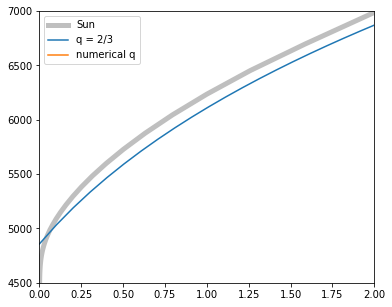

In [2]:
data = np.genfromtxt('https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L16-GreyAtmospheres/16-sun_model.txt', skip_header=24, skip_footer=229, usecols=(1,2,4), names=True)

fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.set_xlim(0,2)
ax.set_ylim(4500,7000)

ax.plot(10**data['lgTauR'], data['T'], label='Sun', lw=5, c="0.75")

Teff = 5777.0
tau = np.linspace(0, 10, 100)

q = 2.0/3.0
T = (0.75*Teff**4*(tau+q))**0.25
ax.plot(tau, T, label='q = 2/3')

q = 0.7104 - 0.133*np.exp(-3.4488*tau)
T = (0.75*Teff**4*(tau+q))*0.25
ax.plot(tau, T, label='numerical q')
ax.legend(loc=0)

#2. Illustration of the integreal in the $C(\alpha, \tau)$ function

#3. Demo of the numpy mesh grid

In [3]:
x = np.array([1,2,3,4])
y = np.array([10,20])

x_grid, y_grid = np.meshgrid(x, y)

print("The matrices have a shape {}, so [ny, nx]".format(x_grid.shape))

print("Each column of the x matrix has the same value of x:", x_grid)
print("Each row of the y matrix has the same value of y:", y_grid)

print("We can flatten these matrices to forma one-deimensional array:")
x_flat = x_grid.flatten()
y_flat = y_grid.flatten()
print("x: {}".format(x_flat))
print("y: {}".format(y_flat))

print("We cann loop over these new flatten arrays to perform complicated calculations")

Result = np.zeros(x_flat.size)
for i in range(0,Result.size):
  if (x_flat[i] % 2) == 0:
    Result[i] = x_flat[i] + y_flat[i]
  else:
    Result[i] = x_flat[i] - y_flat[i]

print(Result)

print("And then we can reshape our array into a matrix:", Result.reshape(x_grid.shape))

The matrices have a shape (2, 4), so [ny, nx]
Each column of the x matrix has the same value of x: [[1 2 3 4]
 [1 2 3 4]]
Each row of the y matrix has the same value of y: [[10 10 10 10]
 [20 20 20 20]]
We can flatten these matrices to forma one-deimensional array:
x: [1 2 3 4 1 2 3 4]
y: [10 10 10 10 20 20 20 20]
We cann loop over these new flatten arrays to perform complicated calculations
[ -9.  12.  -7.  14. -19.  22. -17.  24.]
And then we can reshape our array into a matrix: [[ -9.  12.  -7.  14.]
 [-19.  22. -17.  24.]]


#4. Calculation of the $C(\alpha, \tau)$ function

In [4]:
n_alpha = 50
n_tau = 5

alpha = np.linspace(0.1, 12, n_alpha)
tau = np.linspace(0, 2, n_tau)

alpha_grid, tau_grid = np.meshgrid(alpha, tau)

alpha_flat = alpha_grid.flatten()
tau_flat = tau_grid.flatten()

C = np.zeros(alpha_flat.size)

def p(tau):
  return 1.0 / (0.75*(tau+2.0/3.0))**0.75

for i in range(0, C.size - 1):
  tt_small = np.linspace(0, tau_flat[i], 1000)
  tt_high = np.linspace(tau_flat[i], 20.0, 1000)

  y = expn(2, tau_flat[i] - tt_small) / (np.exp(p(tt_small)*alpha_flat[i]) - 1) #rest of line cut off think it should be -1
  int_small = np.trapz(y, tt_small)

  y = expn(2, tt_high - tau_flat[i]) / (np.exp(p(tt_high)*alpha_flat[i]) - 1) # rest of line cut off think it should be -1
  int_high = np.trapz(y, tt_high)

  C[i] = int_high - int_small

C = C.reshape(alpha_grid.shape)

print(C)

[[4.64272935e+00 1.19188360e+00 6.12125313e-01 3.78641220e-01
  2.55703694e-01 1.81769641e-01 1.33662476e-01 1.00701719e-01
  7.72843501e-02 6.01939297e-02 4.74587640e-02 3.78090150e-02
  3.03951482e-02 2.46315464e-02 2.01047035e-02 1.65168398e-02
  1.36499601e-02 1.13422256e-02 9.47201930e-03 7.94696359e-03
  6.69621369e-03 5.66496320e-03 4.81047383e-03 4.09917187e-03
  3.50450194e-03 3.00532543e-03 2.58471456e-03 2.22903722e-03
  1.92725704e-03 1.67039444e-03 1.45110879e-03 1.26337241e-03
  1.10221485e-03 9.63521025e-04 8.43871083e-04 7.40412695e-04
  6.50758747e-04 5.72904958e-04 5.05163280e-04 4.46107815e-04
  3.94530715e-04 3.49406101e-04 3.09860416e-04 2.75147990e-04
  2.44630824e-04 2.17761823e-04 1.94070832e-04 1.73152984e-04
  1.54658941e-04 1.38286705e-04]
 [3.98855723e+00 1.08642176e+00 5.92043794e-01 3.88328154e-01
  2.77699832e-01 2.08627322e-01 1.61729185e-01 1.28080438e-01
  1.02993544e-01 8.37649997e-02 6.87214482e-02 5.67680921e-02
  4.71559849e-02 3.93538032e-02 3.297

#5. Let's compare the grey flux with the real Solar flux

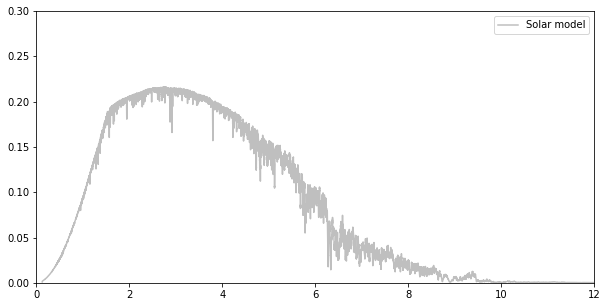

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_xlim(0, 12)
ax.set_ylim(0, 0.30)

Te = 5777*u.K
wave = np.genfromtxt('https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L16-GreyAtmospheres/16-sun_wave.txt')
flux = np.genfromtxt('https://raw.githubusercontent.com/veropetit/PHYS633-S2022/main/L16-GreyAtmospheres/16-sun_flux.txt')

wave = wave/10*u.nm
alp = (const.h*const.c/wave/const.k_B/Te).decompose()

flux = (flux*10 * u.erg/u.s/u.cm**2/u.nm * const.h * const.c / alp**2 / const.k_B / Te) #rest of line cut off
flux = (flux / const.sigma_sb / (Te**4)).decompose()

ax.plot(alp, convolve(flux, Box1DKernel(31)), c = "0.75", label = "Solar model") #rest of line cut off

ax.legend()